## 範例
參考 `train.py` 實現的訓練模型程式碼範例


In [1]:
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.0


In [2]:
pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

     |████████████████████████████████| 317kB 4.9MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [3]:
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# 下載基於 keras 的 yolov3 程式碼
%cd 'gdrive/My Drive/Day41'
# !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
%cd keras-yolo3

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Day41
/content/gdrive/My Drive/Day41/keras-yolo3


In [4]:
import os
if not os.path.exists("model_data/yolo.h5"):
  # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
  print("Model doesn't exist, downloading...")
  os.system("wget https://pjreddie.com/media/files/yolov3.weights")
  print("Converting yolov3.weights to yolo.h5...")
  os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
  print("yolo Model exist")

yolo Model exist


In [5]:
import os
if not os.path.exists("model_data/yolov3-tiny.h5"):
  # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
  print("Model doesn't exist, downloading...")
  os.system(" wget https://pjreddie.com/media/files/yolov3-tiny.weights")
  print("Converting yolov3-tiny.weights to yolov3-tiny.h5...")
  os.system("python convert.py yolov3-tiny.cfg yolov3-tiny.weights model_data/yolov3-tiny.h5")
else:
  print("yolov3-tiny Model exist")

yolov3-tiny Model exist


以下的程式碼負責把下載下來的 Pascal VOC 資料集轉換為訓練模型時需要的格式，直接引用 https://github.com/qqwweee/keras-yolo3/blob/master/voc_annotation.py ，調整了一部分程式碼，讓我們只 sample 前 100 張圖片來做示範，在 colab 中會花一些時間跑完

In [0]:
if not os.path.exists("2020_train.txt"): # 範例中訓練模型時所使用的，已經做好轉換的 annotation 檔名，增加這個檢查避免每次重新跑這段轉換的程式碼
  import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
  from os import getcwd

  sets=[('2020', 'train'), ('2020', 'val'), ('2020', 'test')]

  # Pascal VOC 的資料類別
  classes = ["M"]

  # 把 annotation 轉換訓練時需要的資料形態
  def convert_annotation(year, image_id, list_file):
      in_file = open('VOCdevkit/VOC%s/Annotations/%s.xml'%(year, image_id))
      tree=ET.parse(in_file)
      root = tree.getroot()

      for obj in root.iter('object'):
          difficult = obj.find('difficult').text
          cls = obj.find('name').text
          if cls not in classes or int(difficult)==1:
              continue
          cls_id = classes.index(cls)
          xmlbox = obj.find('bndbox')
          b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
          list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

  wd = "."


  for year, image_set in sets:
      image_ids = open('VOCdevkit/VOC%s/ImageSets/Main/%s.txt'%(year, image_set)).read().strip().split()
      annotation_path = '%s_%s.txt'%(year, image_set)
      list_file = open(annotation_path, 'w')
      print("save annotation at %s" % annotation_path)
      for image_id in image_ids:
          list_file.write('%s/VOCdevkit/VOC%s/JPEGImages/%s.jpg'%(wd, year, image_id))
          convert_annotation(year, image_id, list_file)
          list_file.write('\n')
      list_file.close()


In [7]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

Using TensorFlow backend.


In [0]:
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

把 YOLO weights 轉換為能夠提供給 keras 作為訓練新模型的初始權重，注意這部分多了一個 `-w` 的參數，可以參考 https://github.com/qqwweee/keras-yolo3/blob/master/convert.py#L242 以及 https://stackoverflow.com/questions/42621864/difference-between-keras-model-save-and-model-save-weights 理解其中差別

In [9]:
if not os.path.exists("model_data/yolo_weights.h5"):
  print("Converting pretrained YOLOv3 weights for training")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
  print("Pretrained weights exists")

Pretrained weights exists


In [10]:
annotation_path = '2020_train.txt' # 轉換好格式的標註檔案
val_path = '2020_val.txt'
test_path = '2020_test.txt'
log_dir = 'logs/002/' # 訓練好的模型儲存的路徑
#classes_path = 'model_data/voc_classes.txt'
#anchors_path = 'model_data/yolo_anchors.txt'
classes_path = 'model_data/mango_classes.txt'
anchors_path = 'model_data/yolo_mango_anchors1.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolov3-tiny.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

'''
# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val
'''

with open(annotation_path) as f:
  train = f.readlines()
with open(val_path) as f:
  val = f.readlines()

num_train = int(len(train))
num_val = int(len(val))




# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(data_generator_wrapper(train, batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(val, batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 16 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(train, batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(val, batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final2020.h5')














Create YOLOv3 model with 9 anchors and 1 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 18) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((18,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 18) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((18,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1300 samples, val on 130 samples, with batch size 16.




Epoch 1/50
81/81 [==============================] - 453s 6s/step - loss: 1380.1305 - val_loss: 193.4632

Epoch 2/50
81/81 [==============================] - 103s 1s/step - loss: 168.8443 - val_loss: 111.8556
Epoch 3/50
81/81 [==============================] - 103s 1s/step - loss: 121.9273 - val_loss: 87.9958
Epoch 4/50
81/81 [==============================] - 88s 1s/step - loss: 104.1429 - val_loss: 73.3810
Epoch 5/50
81/81 [==============================] - 102s 1s/step - loss: 94.1590 - val_loss: 71.1469
Epoch 6/50
81/81 [==============================] - 103s 1s/step - loss: 86.9237 - val_loss: 67.2888
Epoch 7/50
81/81 [==============================] - 102s 1s/step - loss: 82.1689 - val_loss: 64.1642
Epoch 8/50
81/81 [===============

In [0]:
from PIL import Image
image = Image.open('gear1n_(1)_04_02.jpg')

In [12]:
from yolo1 import YOLO
classes_path = 'model_data/mango_classes.txt'
yolo_model = YOLO(model_path='logs/001/' + 'trained_weights_final2020.h5', classes_path=classes_path)
r_image = yolo_model.detect_image(image)

logs/001/trained_weights_final2020.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 9 boxes for img
Mango 0.42 (45, 66) (70, 99)
Mango 0.64 (195, 16) (225, 52)
Mango 0.69 (528, 101) (551, 135)
Mango 0.77 (158, 62) (203, 108)
Mango 0.87 (569, 95) (590, 130)
Mango 0.90 (36, 59) (79, 106)
Mango 0.91 (560, 86) (597, 140)
Mango 0.97 (517, 96) (561, 141)
Mango 0.99 (542, 143) (585, 192)
2.6797051659996214


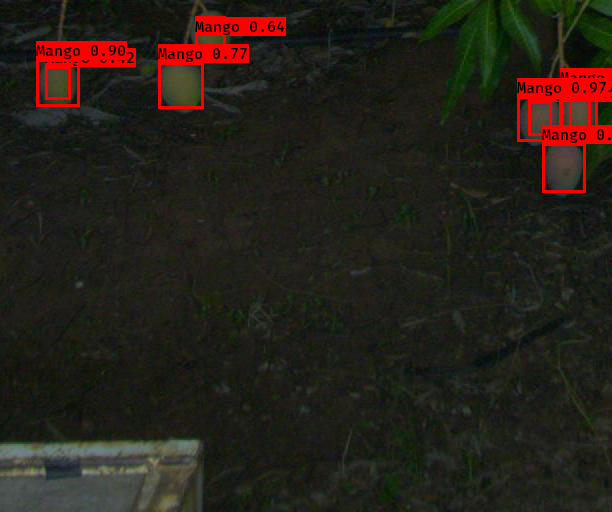

In [13]:
r_image

In [18]:
image1 = Image.open('gear1n_(1)_04_03.jpg')
r_image1 = yolo_model.detect_image(image1)

(416, 416, 3)
Found 4 boxes for img
Mango 0.69 (168, 36) (217, 90)
Mango 0.71 (65, 33) (111, 85)
Mango 0.71 (133, 78) (185, 143)
Mango 0.71 (11, 138) (75, 221)
0.06694982799854188


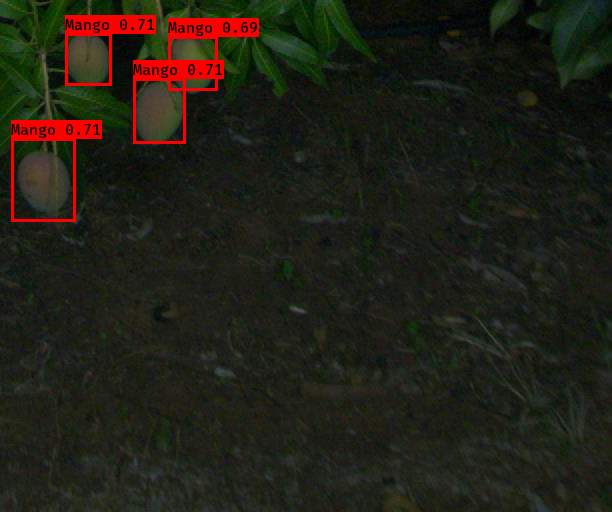

In [19]:
r_image1

In [20]:
image2 = Image.open('gear1n_(10)_03_03.jpg')
r_image2 = yolo_model.detect_image(image2)

(416, 416, 3)
Found 3 boxes for img
Mango 0.35 (466, 135) (512, 177)
Mango 0.92 (234, 424) (262, 461)
Mango 0.98 (478, 140) (501, 168)
0.06451992099937343


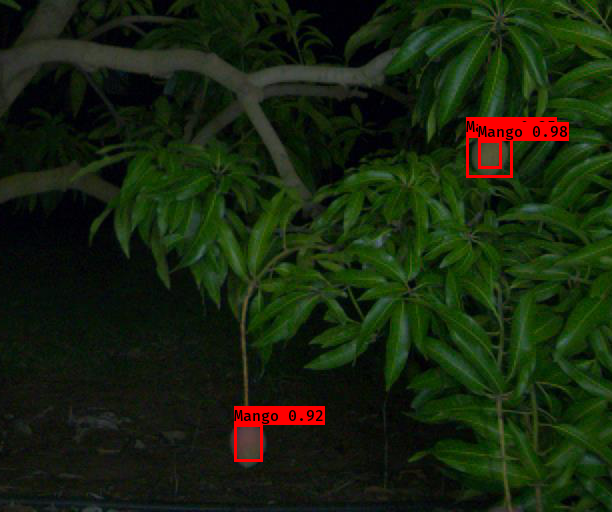

In [21]:
r_image2 

In [22]:
image3 = Image.open('gear1n_(10)_03_02.jpg')
r_image3 = yolo_model.detect_image(image3)

(416, 416, 3)
Found 20 boxes for img
Mango 0.52 (287, 218) (333, 265)
Mango 0.58 (517, 463) (570, 512)
Mango 0.61 (84, 66) (99, 90)
Mango 0.65 (370, 393) (400, 431)
Mango 0.69 (341, 435) (372, 473)
Mango 0.70 (251, 7) (285, 30)
Mango 0.74 (557, 94) (587, 131)
Mango 0.75 (28, 144) (50, 165)
Mango 0.75 (136, 287) (166, 322)
Mango 0.77 (3, 70) (12, 99)
Mango 0.77 (333, 188) (353, 219)
Mango 0.78 (68, 215) (84, 233)
Mango 0.80 (398, 39) (443, 89)
Mango 0.81 (64, 111) (84, 136)
Mango 0.87 (404, 387) (451, 437)
Mango 0.90 (28, 17) (59, 51)
Mango 0.91 (22, 173) (54, 205)
Mango 0.93 (511, 29) (540, 64)
Mango 0.93 (363, 68) (395, 100)
Mango 0.95 (161, 310) (182, 336)
0.09105606999946758


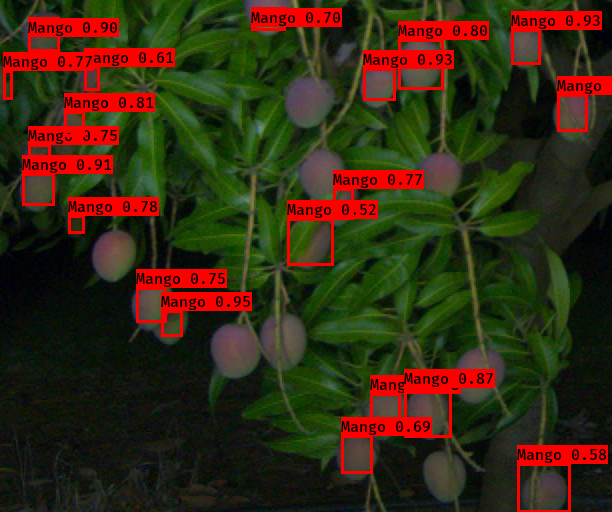

In [23]:
r_image3

In [24]:
image4 = Image.open('gear1n_(11)_02_02.jpg')
r_image4 = yolo_model.detect_image(image4)

(416, 416, 3)
Found 10 boxes for img
Mango 0.66 (366, 86) (397, 136)
Mango 0.77 (21, 5) (44, 20)
Mango 0.78 (353, 191) (383, 232)
Mango 0.94 (140, 329) (170, 365)
Mango 0.96 (497, 261) (509, 278)
Mango 0.96 (234, 394) (263, 429)
Mango 0.97 (506, 277) (520, 297)
Mango 0.98 (390, 87) (412, 116)
Mango 0.98 (303, 56) (326, 87)
Mango 0.99 (371, 95) (389, 129)
0.0749768870009575


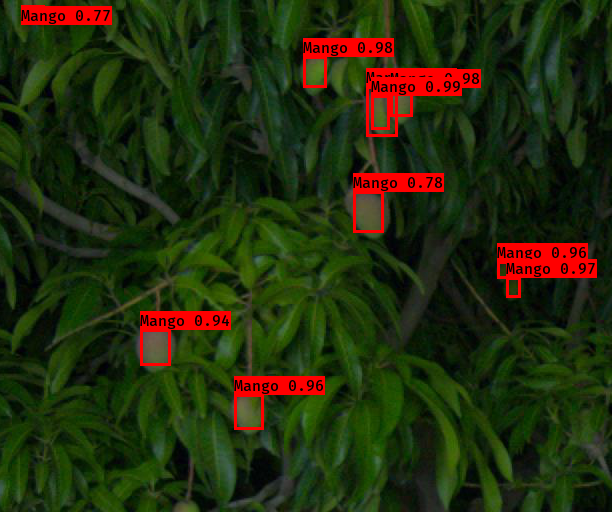

In [25]:
r_image4

In [0]:
#  mAP

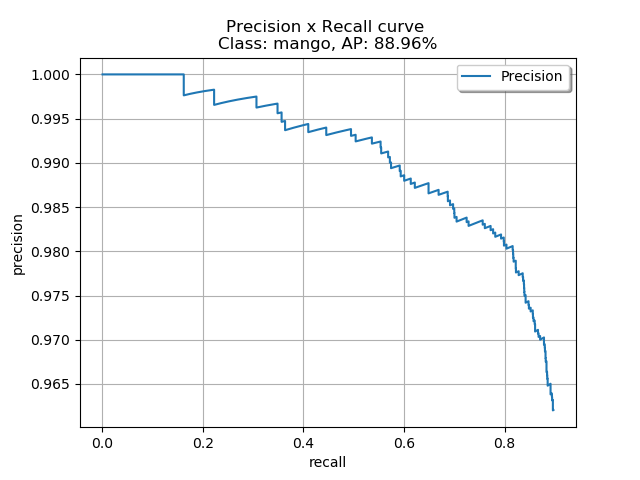

In [17]:
from PIL import Image
image1 = Image.open('mango.png')
image1